In [64]:
import pandas as pd
import numpy as np

from sklearn.linear_model import LogisticRegression
from sklearn.model_selection import train_test_split
from sklearn.metrics import ConfusionMatrixDisplay, confusion_matrix

import matplotlib.pyplot as plt
import matplotlib.animation as animation
from matplotlib.animation import FuncAnimation

#%matplotlib notebook

In [65]:
data = pd.read_json("parsed/my_replays.json")
#data.set_index(['id','f'],inplace=True)
data.head()

,f,ix,t,x,y,z,dx,dy,dz,scorer,pt,month,id
0,0,0,12.733936,0.00,0.00,92.87,0.00,0.00,0.00,1.0,0,2,02BC803B4481747BDB6B6FA3452F2796
1,127,0,18.879103,22.88,-38.32,94.99,1512.35,-2715.01,220.28,1.0,0,2,02BC803B4481747BDB6B6FA3452F2796
2,128,0,18.927488,98.43,-173.95,105.04,1510.01,-2710.87,187.44,1.0,0,2,02BC803B4481747BDB6B6FA3452F2796
3,129,0,18.975874,148.73,-264.25,110.84,1508.45,-2708.11,165.57,1.0,0,2,02BC803B4481747BDB6B6FA3452F2796
4,130,0,19.024260,249.17,-444.58,120.24,1505.33,-2702.59,121.91,1.0,0,2,02BC803B4481747BDB6B6FA3452F2796


In [66]:
data.describe()

,f,ix,t,x,y,z,dx,dy,dz,scorer,pt,month
count,334678.000000,334678.000000,334678.000000,334678.000000,334678.000000,334678.000000,334678.000000,334678.000000,334678.000000,334678.000000,334678.000000,334678.000000
mean,5541.596848,93.861679,244.040719,89.272086,-96.934779,418.518451,0.344782,-15.852722,4.396626,0.554781,4.125506,5.037316
std,3729.014576,65.993175,145.720900,2416.870786,2999.537926,420.582911,905.348108,1052.947806,480.920511,0.476737,3.263182,2.593399
min,0.000000,0.000000,0.400000,-5146.340000,-5994.700000,0.090000,-5060.700000,-4698.220000,-2357.310000,0.000000,0.000000,2.000000
25%,2614.000000,47.000000,123.687223,-1966.907500,-2721.067500,110.870000,-491.647500,-607.250000,-219.170000,0.000000,2.000000,3.000000
50%,5096.000000,92.000000,232.685365,7.360000,-10.120000,267.270000,0.000000,0.000000,0.000000,1.000000,4.000000,5.000000
75%,7655.000000,134.000000,347.379710,2230.845000,2396.987500,598.130000,499.730000,585.665000,214.487500,1.000000,6.000000,6.000000
max,20610.000000,325.000000,728.406740,5146.730000,5990.030000,2000.810000,5893.910000,5163.750000,6785.030000,1.000000,17.000000,10.000000


In [142]:
print(f"Unique plays: {data.groupby(['pt','id']).size().size}")

Unique plays: 407


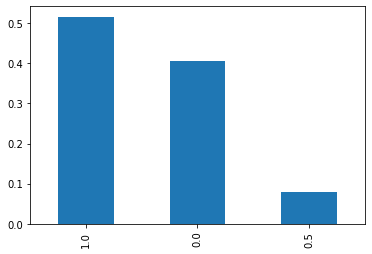

In [67]:
(data.scorer.value_counts() / len(data)).plot(kind='bar')
plt.show()

This actually shows the number of frames captured in points with each scorer,
but in fact the more interesting question is the number of plays with each
label. We can show the distribution of this too.

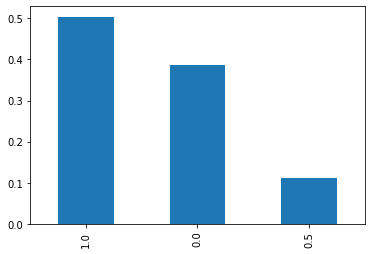

In [147]:
scorers = data.groupby(['id','pt']).agg('mean')['scorer']
(scorers.value_counts() / len(scorers)).plot(kind='bar')
plt.show()

In [148]:
id = data.id.unique()[8]
data.loc[data.id==id, "scorer"].value_counts()

onegame = data.loc[data.id==id]
onepoint = onegame.loc[data.pt==3]


Here's a fun way to examine this data. We can extract one point and animate the ball as it moves around the field.

In [70]:
x = onepoint.y.values
y = onepoint.z.values
color=['C0','C1'][int(onepoint.scorer.mode()[0])]
interval=7
tail = 20
fig,ax = plt.subplots()
WIDTH = 100
HEIGHT = 600 / 5

# ===============
%matplotlib widget

ln, = plt.plot([], [], 'o', c=color, alpha=0.8)

def init():
    ax.set_xlim(-WIDTH,WIDTH)
    ax.set_ylim(-HEIGHT, HEIGHT)
    return ln,

def update(frame):
    #print(frame)
    ln.set_data(x[max(0,frame-tail):frame], y[max(0,frame-tail):frame])
    return ln,

ani = FuncAnimation(fig, update, frames=np.arange(len(x)),
                    init_func=init, blit=True, interval=interval)
plt.show()

ModuleNotFoundError: No module named 'ipympl'

We can learn more about how our variables are distributed by looking at the
location of the ball in the last frame of each play. We should expect all the
scores by team 0 to appear on one end of the field and the scores by team 1 on
the other end of the field, with some neutral balls on the ground in the midfield.

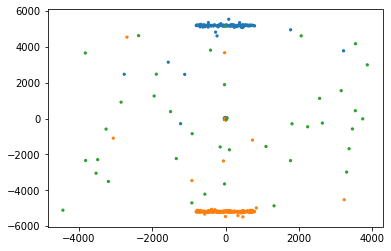

In [150]:
%matplotlib inline
gb = data.groupby(['id', 'pt'])
last_fn = lambda s: s.iloc[-1]
#scorers = gb['scorer'].agg({'scorer':pd.Series.mode, 'ending_x': x_fn, 'ending_y': y_fn
final_seconds = gb.agg({'scorer':pd.Series.mode, 'x':last_fn, 'y':last_fn})

plt.figure()
color_fn = lambda scorer: f"C{int(scorer)}" if scorer % 1 == 0 else "C2"
plt.scatter(final_seconds.x, final_seconds.y, s=5, c=final_seconds.scorer.map(color_fn))
plt.show()

So we can reasonably affirm these relationships:

| Team 0 | Team 1 |
|--|--|
| `+y` | `-y` |

We notice that there's a lot of data clumped in the middle of the field, which
doesn't make sense--the ball will only end there by chance. We look closer at
these points to find the discrepancy.

In [73]:
#plt.figure()
is_weird = (final_seconds.y.abs() < 5000)
is_not_weird = (final_seconds.y.abs() > 5000)
print(f"{is_weird.mean():.2%}")

30.47%


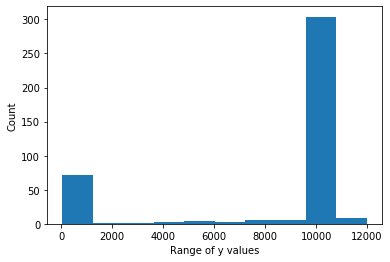

In [151]:
rangeof = lambda s: s.abs().max()*2
is_long = gb.t.agg(max)
ranges = gb.y.agg(rangeof)
plt.hist(ranges)
plt.xlabel("Range of y values")
plt.ylabel("Count")
plt.show()

Max of small-scale: 119.7


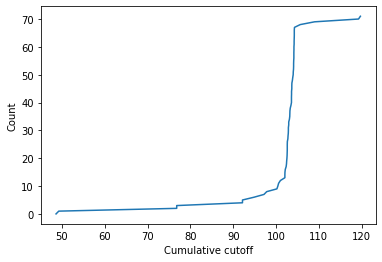

In [156]:
small_ranges = ranges.loc[ranges<150]
plt.plot(sorted(small_ranges), np.arange(len(small_ranges)))
print("Max of small-scale:", max(small_ranges))
plt.ylabel('Count')
plt.xlabel("Cumulative cutoff")
plt.show()

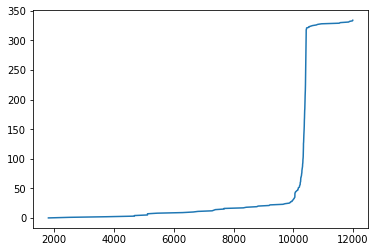

Max of large-scale: 11989.4


In [159]:
large_ranges = ranges.loc[ranges>150]
plt.plot(sorted(large_ranges), np.arange(len(large_ranges)))
plt.show()
print("Max of large-scale:", max(large_ranges))

We can see two identical distributions in this data, replicated at two
completely different scales. There must be something wrong with the sampling. I
wonder if the scale of the replay files changed at some date.

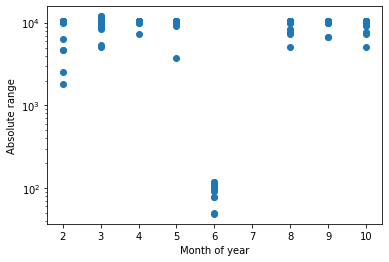

In [160]:
plt.scatter(gb.month.agg('mean'), ranges)
plt.yscale('log')
plt.xlabel("Month of year")
plt.ylabel("Absolute range")
plt.show()

I guess something weird happened in June. We can drop all those entries though.

In [166]:
dataf = data.loc[data.month != 6]
dataf['x_abs'] = dataf['x'].abs()
dataf.head()

C:\Users\Sam\AppData\Roaming\Python\Python37\site-packages\ipykernel_launcher.py:2: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  


,f,ix,t,x,y,z,dx,dy,dz,scorer,pt,month,id,x_abs
0,0,0,12.733936,0.00,0.00,92.87,0.00,0.00,0.00,1.0,0,2,02BC803B4481747BDB6B6FA3452F2796,0.00
1,127,0,18.879103,22.88,-38.32,94.99,1512.35,-2715.01,220.28,1.0,0,2,02BC803B4481747BDB6B6FA3452F2796,22.88
2,128,0,18.927488,98.43,-173.95,105.04,1510.01,-2710.87,187.44,1.0,0,2,02BC803B4481747BDB6B6FA3452F2796,98.43
3,129,0,18.975874,148.73,-264.25,110.84,1508.45,-2708.11,165.57,1.0,0,2,02BC803B4481747BDB6B6FA3452F2796,148.73
4,130,0,19.024260,249.17,-444.58,120.24,1505.33,-2702.59,121.91,1.0,0,2,02BC803B4481747BDB6B6FA3452F2796,249.17


Let's look at those last-second ball locations again, to see if they make more
sense now.

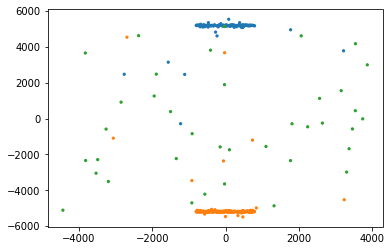

Number of points: 335


In [167]:
gb = dataf.groupby(['id','pt'])
final_seconds = gb.agg({'scorer':pd.Series.mode, 'x':last_fn, 'y':last_fn})

plt.figure()
color_fn = lambda scorer: f"C{int(scorer)}" if scorer % 1 == 0 else "C2"
plt.scatter(final_seconds.x, final_seconds.y, s=5, c=final_seconds.scorer.map(color_fn))
plt.show()
print("Number of points:", len(final_seconds))

The clump of data in the center has disappeared, but there's still a lot of blue
and orange points scattered around the midfield. I'm not sure why that would be.
Something like overtime might be the culprit, although I haven't figured out
exactly how that could be the case.

## Training

We assign the replays to test and train by IDs, so that we don't have data from the same replay in both the training and testing sets.

In [170]:
train_ids, test_ids = train_test_split(dataf.id.unique())

features = ['x', 'y', 'z', 'dx', 'dy', 'dz','x_abs']

X_train = dataf.loc[data.id.isin(train_ids), features]
y_train = dataf.loc[data.id.isin(train_ids), 'scorer']
X_test = dataf.loc[data.id.isin(test_ids), features]
y_test = dataf.loc[data.id.isin(test_ids), 'scorer']
#X_train, X_test, y_train, y_test = train_test_split(X, gb['scorer'])

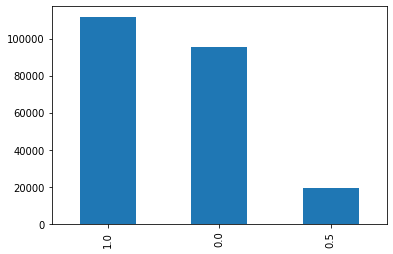

In [171]:
# Check for bias in training data
plt.figure()
y_train.value_counts().plot(kind='bar')

First we'll see how effective a simple logistic regression can be.

In [173]:
reclass = {0:0,1:1,0.5:2,2:2}
y_train = y_train.map(reclass)
y_test = y_test.map(reclass)

model = LogisticRegression(multi_class='multinomial')
model.fit(X_train, y_train)

C:\Users\Sam\.conda\envs\datasci\lib\site-packages\sklearn\linear_model\_logistic.py:940: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/stable/modules/linear_model.html#logistic-regression
  extra_warning_msg=_LOGISTIC_SOLVER_CONVERGENCE_MSG)


LogisticRegression(C=1.0, class_weight=None, dual=False, fit_intercept=True,
                   intercept_scaling=1, l1_ratio=None, max_iter=100,
                   multi_class='multinomial', n_jobs=None, penalty='l2',
                   random_state=None, solver='lbfgs', tol=0.0001, verbose=0,
                   warm_start=False)

In [174]:
y_pred = model.predict(X_test)
print(f"Test accuracy: {(y_pred == y_test).mean():.2%}")

Test accuracy: 57.43%


Because our most common class covers just over 50% of the testing data, this
isn't really a significant result. We examine a confusion matrix below to see
where these errors are coming from.

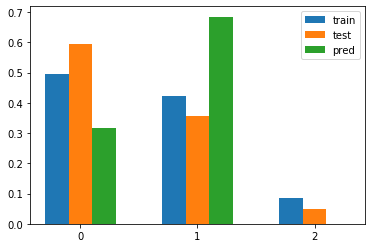

In [175]:
width = 0.2
xticks  = np.arange(3)
labels, counts = np.unique(y_pred, return_counts=True)
counts = [(y_pred == n).mean() for n in [0,1,2]]

plt.bar(xticks - width, y_train.value_counts() / len(y_train), width, label='train')
plt.bar(xticks, y_test.value_counts() / len(y_test),width, label='test')
plt.bar(xticks + width, counts, width, label='pred')
plt.xticks(xticks)
plt.legend()

plt.show()

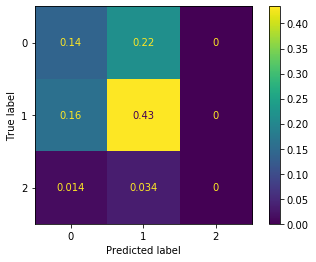

In [176]:
ConfusionMatrixDisplay(confusion_matrix(y_test, y_pred)/len(y_test), [0,1,2]).plot()

So our model tends to overpredict on one particular class. Not sure why that is,
it's not even choosing the most common class in the training set.

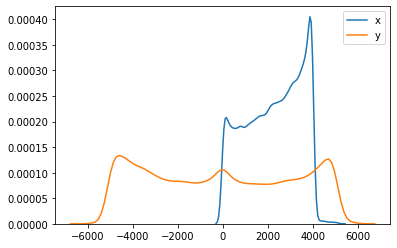

In [177]:
import seaborn as sns

sns.kdeplot(dataf.x.abs())
sns.kdeplot(dataf.y)
plt.show()

I want to look at the model coefficients to understand how the model is
predicting, but first I have to examine the distributions of the variables to
see that they're reasonable. They're kind of not. I'll need to rescale before I
can compare the coefficient weights.